# ML Project: Fraud Detection for STEG

The Tunisian Company of Electricity and Gas (STEG) is a public and a non-administrative company, it is responsible for delivering electricity and gas across Tunisia. The company suffered tremendous losses in the order of 200 million Tunisian Dinars due to fraudulent manipulations of meters by consumers. Using the client’s billing history, our aim is to detect and recognize clients involved in fraudulent activities.

## Data Product

- Goal: develop fraud-detection system that identifies clients involved in fraudulent activities while leaving non-fraudulent clients aside. 
- Value of Product: enhance the company’s revenues by reducing the losses caused by fraudulent activities, avoid reputation damage.
- Evaluation Metric: ROC-AUC (True Positive Rate and True Negative Rate will also be inspected).
- Baseline Model: coin toss, since no intuitive baseline model gave good results.

## Setup

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import missingno as msno
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, recall_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(context='notebook', style='darkgrid')

RSEED = 12345

## Data Import and Cleaning

The following column documentation was provided by the STEG:

- Client_id: Unique id for client
- District: District where the client is
- Client_catg: Category client belongs to
- Region: Area where the client is
- Creation_date: Date client joined
- Target: fraud:1 , not fraud: 0
- Invoice_date: Date of the invoice
- Tarif_type: Type of tax
- Counter_number:
- Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
- Counter_code:
- Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
- Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
- Consommation_level_1: Consumption_level_1
- Consommation_level_2: Consumption_level_2
- Consommation_level_3: Consumption_level_3
- Consommation_level_4: Consumption_level_4
- Old_index: Old index
- New_index: New index
- Months_number: Month number
- Counter_type: Type of counter

Unfortunately, this is not a very good documentation. Some columns are left unexplained, and most explanations are not helpful.

In [2]:
# Loading the data
df_client = pl.read_csv("data/client_train.csv", ignore_errors=True)
df_invoice = pl.read_csv("data/invoice_train.csv", ignore_errors=True)

# Merging
df = df_invoice.join(df_client, on = "client_id")

# Dropping duplicates
duplicates = len(df) - len(df.unique())
print(f"Number of dropped duplicate rows: {duplicates}")
df = df.unique()

# Converting counter_type from string to integer
df = df.with_columns(pl.col(["counter_type"]).replace_strict({"ELEC": 1, "GAZ": 0}))

# Cleaning counter_statue column
df = df.filter(pl.col(["counter_statue"]) <=5)

# Replace Nan with Null values
df.with_columns(pl.col(pl.Float32, pl.Float64).fill_nan(None))

# Null values
nulls = int(df.null_count().sum_horizontal().to_numpy())
print(f"Number of nulls: {nulls}")

# Ruling out transactions earlier than 2005
df = df.with_columns(pl.col(["invoice_date"]).str.to_datetime(format="%Y-%m-%d"))
df = df.with_columns(pl.col(["creation_date"]).str.to_datetime(format="%d/%m/%Y"))

# Chaning data type of target
df = df.with_columns(df["target"].cast(pl.Int8))

# Overview of the data
display(df)

Number of dropped duplicate rows: 11
Number of nulls: 0


client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
str,datetime[μs],i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,datetime[μs],i8
"""train_Client_9515""",2016-03-08 00:00:00,11,1056043,0,207,6,1,376,0,0,0,11041,11417,4,1,69,11,104,2006-07-17 00:00:00,0
"""train_Client_133730""",2018-06-02 00:00:00,10,564049,0,202,9,1,31,0,0,0,9483,9514,3,1,62,11,301,2017-11-01 00:00:00,0
"""train_Client_104377""",2010-05-07 00:00:00,40,51133,0,5,6,1,0,0,0,0,0,0,4,0,60,11,101,1994-05-27 00:00:00,0
"""train_Client_39419""",2015-09-22 00:00:00,11,12115,0,203,9,1,1371,0,0,0,2310,3681,8,1,62,11,303,2000-10-04 00:00:00,1
"""train_Client_111912""",2018-04-06 00:00:00,40,45266,0,5,8,1,118,0,0,0,4129,4247,4,0,62,11,303,2008-01-14 00:00:00,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""train_Client_21544""",2014-02-14 00:00:00,11,665151,0,203,9,1,433,0,0,0,21563,21996,4,1,60,11,101,1987-06-22 00:00:00,0
"""train_Client_81306""",2015-04-15 00:00:00,11,57989,0,203,8,1,362,0,0,0,11264,11626,4,1,63,11,306,2010-04-07 00:00:00,0
"""train_Client_86492""",2013-11-12 00:00:00,11,703382,1,203,9,1,1200,622,0,0,40951,42773,4,1,62,11,371,2008-02-18 00:00:00,0


## Statistical Properties

In [ ]:
# Statistical overview
df.describe()

### Electricity Fraud vs. Gas Fraud

There is *much* more fraudulent activity in electricity than in gas. And obviously, there in much more non-fraudulent than fraudulent activity.

In [ ]:
sns.histplot(df, x = "counter_type", hue = "target");

## Resampling

Since our dataset is highly unbalanced, we *undersample* the majority class, i.e. non-fraudulent cases.

In [3]:
# Dropping features
dropped_features = ["client_id","counter_number","invoice_date","target"]

# Defining target and features
y = np.array(df["target"])
X = np.array(df.drop(dropped_features))

# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=RSEED)

# Assuming X_train, y_train are your feature and target datasets
# Perform downsampling on the majority class
X_downsampled, y_downsampled = resample(X_train[y_train == 0],
                                         y_train[y_train == 0],
                                         replace=False,
                                         n_samples=np.sum(y_train == 1),
                                         random_state=RSEED)

# Concatenate the downsampled data with the minority class data
X_balanced = np.concatenate((X_downsampled, X_train[y_train == 1]))
y_balanced = np.concatenate((y_downsampled, y_train[y_train == 1]))

## Baseline Model

Our EDA gave no interesting results as to which feature could serve as a good baseline predictor. We therefore take a simple coinflip as baseline model.

In [ ]:
# Start timer
t = time.time()

# Creating column with coin flip results
number_rows = len(y_test)
y_test_pred_coin = np.random.randint(2, size=number_rows)

# Stop timer
elapsed = time.time() - t

# Plotting 
cf_matrix = confusion_matrix(y_test,y_test_pred_coin)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
plt.title("Confusion Matrix for Coin Flip")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Metrics
roc_auc = roc_auc_score(y_test, y_test_pred_coin)
tpr = recall_score(y_test, y_test_pred_coin)
tnr = recall_score(y_test, y_test_pred_coin, pos_label=0)

# Store metrics
coint_metrics = pl.DataFrame({
    "Model": "Coin Flip", 
    "ROC-AUC": [roc_auc], 
    "True Positive Rate": [tpr], 
    "True Negative Rate": [tnr],
    "Elapsed Time in Seconds": [elapsed],
})

# 
coint_metrics

## Testing Classifiers

Tested Classifiers:

1. KNN: prediction takes too much time because of dataset size.
2. Decision Trees: good performance out-of-the-box, can be fine-tuned with good data-cleaning.
3. Random Forests: slightly worse performance than Decision Trees, computational time okay.
4. Extra Trees: slightly worse performance than Decision Trees, computational time short-
3. K-Means: fast but poor classification performance.
4. LightGBM: fast but poor performance.
5. XGboost: fast but poor performance.
6. Logistic Regression: fast computation, but poor performance.
7. AdaBoost: slow and poor performance.
8. SVM: very slow, cancelled after several hours.
9. Naive Bayes Classifier: fast but poor performance.


In [ ]:
# Model list
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_jobs=-1),
    "Extra Trees": ExtraTreesClassifier(n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(),
    "LightGBM": LGBMClassifier(n_jobs=-1,verbosity=-1),
    "XGBoost": XGBClassifier(n_jobs=-1),
    "CatBoost": CatBoostClassifier(verbose=0,),
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(n_jobs=-1)
}

# Initiate storage for each model
all_metrics = pl.DataFrame()

# Loop through models
for model_name, model in models.items():

    # Start timer
    t = time.time()

    # Initializing and fitting pipeline with standard scaler
    pipe = Pipeline([('scale', StandardScaler()),(model_name, model)]).fit(X_balanced, y_balanced)
    
    # Predict
    y_test_pred = pipe.predict(X_test)
    y_test_pred_prob = pipe.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Stop timer
    elapsed = time.time() - t
    
    # # Confusion Matrix
    # cf_matrix = confusion_matrix(y_test, y_test_pred)
    
    # # Plotting Confusion Matrix
    # sns.heatmap(cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
    # plt.title(f"Confusion Matrix for {model_name}")
    # plt.xlabel("Predicted label")
    # plt.ylabel("True label")
    # plt.show()
    
    # Metrics
    roc_auc = roc_auc_score(y_test, y_test_pred_prob) if y_test_pred_prob is not None else None
    tpr = recall_score(y_test, y_test_pred)
    tnr = recall_score(y_test, y_test_pred, pos_label=0)
    
    # Store metrics
    model_metrics = pl.DataFrame({
        "Model": [model_name], 
        "ROC-AUC": [roc_auc], 
        "True Positive Rate": [tpr], 
        "True Negative Rate": [tnr],
        "Elapsed Time in Seconds": [elapsed],
    })
    
    # Concatenate
    all_metrics = pl.concat([all_metrics, model_metrics])

# Display metrics
pl.Config.set_tbl_hide_column_data_types(True)  
display(all_metrics)

## Decision Tree Optimization

Out of the box, a simple Decision Tree Classifier performs better than some more sophisticated models. Let us tune the hyperparameters of our Decision Tree Classifier to improve its performance even more.

In [ ]:
# Defining parameter grid (as dictionary)
param_grid = {"criterion": ["log_loss"],
            "random_state" : [RSEED],
            "max_depth" : [None],
              }

# Instantiate and fit gridsearch
gs = GridSearchCV(DecisionTreeClassifier(), param_grid, scoring="roc_auc", cv=5, verbose=5, n_jobs=-1).fit(X_balanced, y_balanced)

# Best results
print('Best score:', round(gs.best_score_, 3))
print('Best parameters:', gs.best_params_)

# Predict
y_test_pred = gs.best_estimator_.predict(X_test)
y_test_pred_prob = gs.best_estimator_.predict_proba(X_test)[:, 1] if hasattr(gs.best_estimator_, "predict_proba") else None

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting Confusion Matrix
sns.heatmap(cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
plt.title(f"Confusion Matrix for Optimized Decision Tree")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Metrics
roc_auc = roc_auc_score(y_test, y_test_pred_prob) if y_test_pred_prob is not None else None
tpr = recall_score(y_test, y_test_pred)
tnr = recall_score(y_test, y_test_pred, pos_label=0)

# Store metrics
model_metrics = pl.DataFrame({
    "Model": ["Optimized Decision Tree"], 
    "ROC-AUC": [roc_auc], 
    "True Positive Rate": [tpr], 
    "True Negative Rate": [tnr],
})

# Present results
pl.Config.set_tbl_hide_column_data_types(True)  
display(model_metrics)

## Random Forest Optimization

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 3/5] END max_depth=10, n_estimators=200, n_jobs=-1, random_state=12345;, score=0.705 total time= 1.8min
[CV 1/5] END max_depth=10, n_estimators=200, n_jobs=-1, random_state=12345;, score=0.704 total time= 1.8min
[CV 5/5] END max_depth=10, n_estimators=200, n_jobs=-1, random_state=12345;, score=0.708 total time= 1.8min
[CV 2/5] END max_depth=10, n_estimators=200, n_jobs=-1, random_state=12345;, score=0.709 total time= 1.8min
[CV 4/5] END max_depth=10, n_estimators=200, n_jobs=-1, random_state=12345;, score=0.706 total time= 1.9min
Best score: 0.706
Best parameters: {'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 12345}


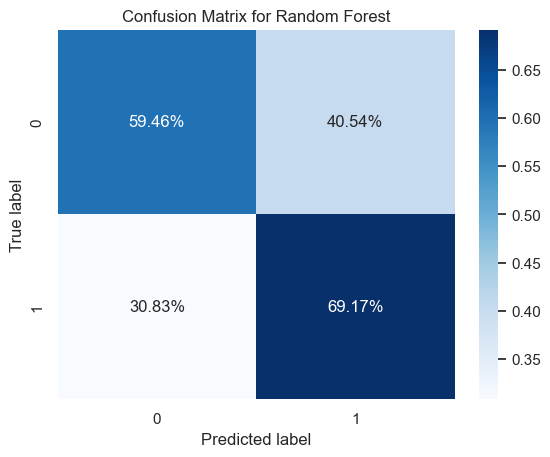

Model,ROC-AUC,True Positive Rate,True Negative Rate
"""Optimized Random Forest""",0.7063,0.691673,0.594615


In [7]:
# Defining parameter grid (as dictionary)
param_grid = {"n_estimators": [100,150],
            "criterion" : ["log_loss"],
            "random_state" : [RSEED],
            "n_jobs": [-1],
              }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(RandomForestClassifier(), param_grid, scoring="roc_auc", cv=5, verbose=5, n_jobs=-1).fit(X_balanced, y_balanced)

# Best results
print('Best score:', round(gs.best_score_, 3))
print('Best parameters:', gs.best_params_)

# Predict
y_test_pred = gs.best_estimator_.predict(X_test)
y_test_pred_prob = gs.best_estimator_.predict_proba(X_test)[:, 1] if hasattr(gs.best_estimator_, "predict_proba") else None

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting Confusion Matrix
sns.heatmap(cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
plt.title(f"Confusion Matrix for Random Forest")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Metrics
roc_auc = roc_auc_score(y_test, y_test_pred_prob) if y_test_pred_prob is not None else None
tpr = recall_score(y_test, y_test_pred)
tnr = recall_score(y_test, y_test_pred, pos_label=0)

# Store metrics
model_metrics = pl.DataFrame({
    "Model": ["Optimized Random Forest"], 
    "ROC-AUC": [roc_auc], 
    "True Positive Rate": [tpr], 
    "True Negative Rate": [tnr]
})

# Present results
pl.Config.set_tbl_hide_column_data_types(True)  
display(model_metrics)

## XGBoost Optimization

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 2/5] END learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1500, n_jobs=-1, random_state=12345;, score=0.882 total time= 2.2min
[CV 1/5] END learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1500, n_jobs=-1, random_state=12345;, score=0.879 total time= 2.2min
[CV 5/5] END learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1500, n_jobs=-1, random_state=12345;, score=0.880 total time= 2.2min
[CV 3/5] END learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1500, n_jobs=-1, random_state=12345;, score=0.879 total time= 2.4min
[CV 4/5] END learning_rate=0.3, max_depth=10, min_child_weight=1, n_estimators=1500, n_jobs=-1, random_state=12345;, score=0.878 total time= 2.5min
Best score: 0.88
Best parameters: {'learning_rate': 0.3, 'max_depth': 10, 'min_child_weight': 1, 'n_estimators': 1500, 'n_jobs': -1, 'random_state': 12345}


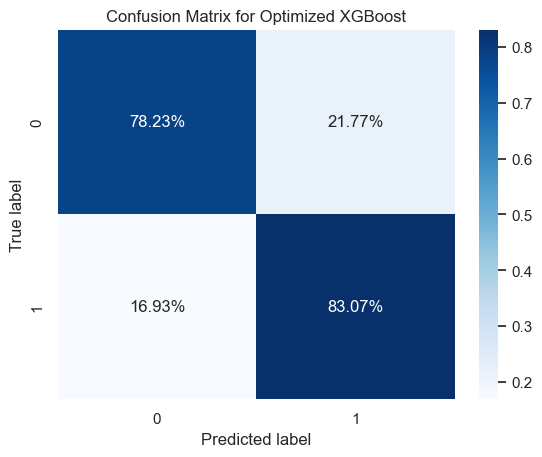

Model,ROC-AUC,True Positive Rate,True Negative Rate
"""Optimized XGBoost""",0.891098,0.830667,0.782283


In [4]:
# Defining parameter grid (as dictionary)
param_grid = {"n_estimators": [1500],
            "max_depth": [10],
            'min_child_weight': [1],
            "random_state" : [RSEED],
            "learning_rate": [.3],
            "n_jobs": [-1],
              }

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(XGBClassifier(), param_grid, scoring="roc_auc", cv=5, verbose=5, n_jobs=-1).fit(X_balanced, y_balanced)

# Best results
print('Best score:', round(gs.best_score_, 3))
print('Best parameters:', gs.best_params_)

# Predict
y_test_pred = gs.best_estimator_.predict(X_test)
y_test_pred_prob = gs.best_estimator_.predict_proba(X_test)[:, 1] if hasattr(gs.best_estimator_, "predict_proba") else None

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_test_pred)

# Plotting Confusion Matrix
sns.heatmap(cf_matrix / cf_matrix.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
plt.title(f"Confusion Matrix for Optimized XGBoost")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

# Metrics
roc_auc = roc_auc_score(y_test, y_test_pred_prob) if y_test_pred_prob is not None else None
tpr = recall_score(y_test, y_test_pred)
tnr = recall_score(y_test, y_test_pred, pos_label=0)

# Store metrics
model_metrics = pl.DataFrame({
    "Model": ["Optimized XGBoost"], 
    "ROC-AUC": [roc_auc], 
    "True Positive Rate": [tpr], 
    "True Negative Rate": [tnr]
})

# Present results
pl.Config.set_tbl_hide_column_data_types(True)  
display(model_metrics)

## Threshold Finetuning

In [ ]:
# Plot AUC/ROC curve
fpr, tpr, thresholds = roc_curve(y_test,  y_test_pred_prob)

fig, ax = plt.subplots(figsize=(6,6))
ax.plot(fpr, tpr)
ax.set_title('ROC Curve for Tuned Decision Tree')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate');

## Feature Importance

In [ ]:
# Getting feature importance plus labels
feat_importance = gs.best_estimator_.feature_importances_
x_labels = df.drop(dropped_features).columns

pl.DataFrame({"Feature": x_labels, "Importance": feat_importance}).sort(by="Importance",descending=True).head(10)